In [1]:
# Yiming Guo 07/14/2024
"""
./bin/ycsb run basic -p recordcount=100 -p operationcount=500000 -p workload=site.ycsb.workloads.CoreWorkload -p requestdistribution=hotspot -p hotspotdatafraction=0.2 -p hotspotopnfraction=0.8 -p readproportion=1.0 -p insertorder=ordered -p updateproportion=0 -s > data/tracea_load.txt
"""
import os
import subprocess
import time
import csv
import pandas as pd
import numpy as np
from collections import Counter
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
# import torch

# torch.cuda.empty_cache()
# print("CUDA 是否可用:", torch.cuda.is_available())
# print("当前 CUDA 设备数量:", torch.cuda.device_count())
# print("当前 CUDA 设备名称:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "无")
import torch

# 检查 CUDA 可用性
print("CUDA 是否可用:", torch.cuda.is_available())
print("当前 CUDA 设备数量:", torch.cuda.device_count())

# 如果 CUDA 不可用，尝试找出原因
if not torch.cuda.is_available():
    print("\nCUDA 不可用的可能原因:")
    
    # 检查是否安装了 GPU 版本的 PyTorch
    print("PyTorch 版本:", torch.__version__)
    
    # 检查 CUDA 是否在系统上可用
    try:
        import subprocess
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if result.returncode != 0:
            print("1. 系统中没有 NVIDIA GPU 或 NVIDIA 驱动程序未正确安装")
        else:
            print("1. 系统中有 NVIDIA GPU，但 PyTorch 可能未编译为 GPU 版本")
    except:
        print("1. 无法执行 nvidia-smi 命令")
    
    # 检查是否安装了正确版本的 PyTorch
    print("2. 您可能安装了 CPU 版本的 PyTorch，而不是 GPU 版本")
    
    # 建议的解决方案
    print("\n解决方案:")
    print("a. 确保系统中有 NVIDIA GPU")
    print("b. 安装 NVIDIA 驱动程序 (使用 nvidia-smi 检查)")
    print("c. 安装 CUDA 工具包")
    print("d. 安装与您 CUDA 版本匹配的 GPU 版本 PyTorch:")
    print("   访问 https://pytorch.org/get-started/locally/ 获取正确的安装命令")
    
    # 示例安装命令
    print("\n例如，对于 CUDA 11.7:")
    print("pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117")
else:
    print("当前 CUDA 设备名称:", torch.cuda.get_device_name(0))

CUDA 是否可用: True
当前 CUDA 设备数量: 1
当前 CUDA 设备名称: NVIDIA GeForce GTX 1650 Ti


In [3]:


YCSB_PATH = "/home/ming/桌面/Lion/YCSB"  # YCSB安装路径
OUTPUT_FILE = "/home/ming/桌面/Lion/ycsb_hotspot_result.txt"  # 原始结果输出文件
PROCESSED_FILE = "/home/ming/桌面/Lion/lstm_dataset.csv"  # 处理后的数据集文件
LOG_FILE = "/home/ming/桌面/Lion/query_log.txt"  # 详细查询日志文件
MODEL_PATH = "/home/ming/桌面/Lion/hotspot_predictor.pth"  # 模型保存路径
RECORD_COUNT = 100  # 数据集大小
OPERATION_COUNT = 500000  # 查询操作数量
HOTSPOT_FRACTION = 0.2  # 20%的热点键
HOTSPOT_OPS_FRACTION = 0.8  # 80%的操作访问热点
WINDOW_SIZE_MS = 100  # 时间窗口大小(毫秒)
SEQUENCE_LENGTH = 10  # 输入序列长度(时间窗口数)
KEYS_PER_WINDOW = 20  # 每个时间窗口跟踪的热键数量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")


使用设备: cuda


In [ ]:
import subprocess
import os

def run_ycsb_command():
    ycsb_dir = "/home/ming/桌面/PLIN-N /PLIN-N/YCSB"
    original_dir = os.getcwd()
    os.chdir(ycsb_dir)

    # # load
    # load_command = [
    #     "./bin/ycsb", "load", "basic",
    #     "-p", "recordcount=10000000",    # total 10000000 10000000
    #     "-p", "operationcount=50000000",
    #     "-p", "workload=site.ycsb.workloads.CoreWorkload",
    #     "-p", "requestdistribution=zipfian",
    #     # "-p", "hotspotdatafraction=0.2",
    #     # "-p", "hotspotopnfraction=0.8",
    #     "-p", "readproportion=1.0",
    #     "-p", "insertorder=ordered",
    #     "-p", "updateproportion=0",
    #     "-p","readallfields=true",
    #     "-s"
    # ]
    
    # with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_load.txt", "w") as f:
    #     subprocess.run(load_command, stdout=f, stderr=subprocess.PIPE, text=True)

    # # run
    # run_command = [
    #     "./bin/ycsb", "run", "basic",
    #     "-p", "recordcount=10000000",  
    #     "-p", "operationcount=50000000", 
    #     "-p", "workload=site.ycsb.workloads.CoreWorkload",
    #     "-p", "requestdistribution=zipfian",
    #     # "-p", "hotspotdatafraction=0.2",
    #     # "-p", "hotspotopnfraction=0.8",
    #     "-p", "readproportion=1.0",
    #     "-p", "insertorder=ordered",
    #     "-p", "updateproportion=0",
    #     "-p","readallfields=true",
    #     "-s"
    # ]
    # f.close()
    # load
    load_command = [
        "./bin/ycsb", "load", "basic",
        "-p", "recordcount=1000000",    # total 10000000
        "-p", "operationcount=25000000",
        "-p", "workload=site.ycsb.workloads.CoreWorkload",
        "-p", "requestdistribution=zipfian",
        "-p", "readproportion=1.0",
        "-p", "insertorder=ordered",
        "-p", "updateproportion=0",
        "-p","readallfields=true",
        "-s"
    ]
    
    with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_load.txt", "w") as f:
        subprocess.run(load_command, stdout=f, stderr=subprocess.PIPE, text=True)

    # run
    run_command = [
        "./bin/ycsb", "run", "basic",
        "-p", "recordcount=1000000",  
        "-p", "operationcount=25000000", 
        "-p", "workload=site.ycsb.workloads.CoreWorkload",
        "-p", "requestdistribution=zipfian",
        "-p", "readproportion=1.0",
        "-p", "insertorder=ordered",
        "-p", "updateproportion=0",
        "-p","readallfields=true",
        "-s"
    ]
    f.close()
    
    with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_run.txt", "w") as f1:
        subprocess.run(run_command, stdout=f1, stderr=subprocess.PIPE, text=True)

    os.chdir(original_dir)

run_ycsb_command()

In [ ]:
import subprocess
import os

def run_ycsb_command():
    ycsb_dir = "/home/ming/桌面/PLIN-N /PLIN-N/YCSB"
    original_dir = os.getcwd()
    os.chdir(ycsb_dir)

    load_command = [
        "./bin/ycsb", "load", "basic",
        "-p", "recordcount=1000000",    # total 10000000
        "-p", "operationcount=25000000",
        "-p", "workload=site.ycsb.workloads.CoreWorkload",
        "-p", "requestdistribution=zipfian",
        "-p", "readproportion=1.0",
        "-p", "insertorder=ordered",
        "-p", "updateproportion=0",
        "-p","readallfields=true",
        "-s"
    ]
    
    with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_load.txt", "w") as f:
        subprocess.run(load_command, stdout=f, stderr=subprocess.PIPE, text=True)

    # run
    run_command = [
        "./bin/ycsb", "run", "basic",
        "-p", "recordcount=1000000",  
        "-p", "operationcount=25000000", 
        "-p", "workload=site.ycsb.workloads.CoreWorkload",
        "-p", "requestdistribution=zipfian",
        "-p", "readproportion=1.0",
        "-p", "insertorder=ordered",
        "-p", "updateproportion=0",
        "-p","readallfields=true",
        "-s"
    ]
    f.close()
    
    with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_run.txt", "w") as f1:
        subprocess.run(run_command, stdout=f1, stderr=subprocess.PIPE, text=True)

    os.chdir(original_dir)

run_ycsb_command()

In [ ]:
import re
import sys
from collections import defaultdict

input_file = "/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_run.txt"
output_file = "/home/ming/桌面/PLIN-N /PLIN-N/build/command_plus.txt"
output_file_summary = "/home/ming/桌面/PLIN-N /PLIN-N/build/processed_key_summary.txt"

def extract_keys_from_ycsb_log(input_file, output_file):
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            log_content = f.readlines()
        
        key_counts = defaultdict(int)
        total_keys = 0
        keys = []
         
        for line in log_content:
            match = None
            if 'READ usertable' in line:
                match = re.search(r'READ usertable (\w+)', line)
            elif 'UPDATE usertable' in line:
                match = re.search(r'UPDATE usertable (\w+)', line)
            elif 'DELETE usertable' in line:
                match = re.search(r'DELETE usertable (\w+)', line)
            
            if match:
                key = match.group(1)
                keys.append("find " + match.group(1)[4:])
                if key.startswith("user"):
                    key = key[4:]
                key_counts[key] += 1
                total_keys += 1
        

        sorted_keys = sorted(key_counts.items(), key=lambda x: x[1], reverse=True)

        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("key\n")
            for key in keys:
                f.write(f"{key}\n")
        
        print(f"extract {len(keys)} keys to {output_file}")
        
        with open(output_file_summary, 'w', encoding='utf-8') as f:
            f.write(f"总键访问次数: {total_keys}\n")
            f.write(f"唯一键数量: {len(key_counts)}\n\n")
            f.write("键访问统计 (按访问次数降序):\n")
            for key, count in sorted_keys:
                f.write(f"{key}: {count}\n")
        
        print(f"成功处理 {total_keys} 次键访问，涉及 {len(key_counts)} 个唯一键")
        print(f"结果已保存到: {output_file}")
        # print("\n前10个最常访问的键:")
        # for i, (key, count) in enumerate(sorted_keys[:10], 1):
        #     print(f"{i}. {key}: {count} 次")
       
    except FileNotFoundError:
        print(f"错误: 找不到文件 {input_file}")
    except Exception as e:
        print(f"处理文件时出错: {e}")

extract_keys_from_ycsb_log(input_file, output_file)

In [ ]:
import numpy as np
import pandas as pd
import random
import time
from datetime import datetime, timedelta
import json
import os
from collections import defaultdict, Counter

class WorkloadGenerator:
    def __init__(self, num_devices=10, total_keys=100000, zipf_param=1.2, 
                 cycle_duration=30, total_cycles=10, output_dir="./workload_logs"):
        """
        初始化工作负载生成器
        
        参数:
        num_devices: 设备数量
        total_keys: 总键数量
        zipf_param: Zipf分布参数，控制28定律的倾斜程度
        cycle_duration: 每个设备在周期内的持续时间(秒)
        total_cycles: 总周期数（每个周期包含所有设备的访问）
        output_dir: 输出目录
        """
        self.num_devices = num_devices
        self.total_keys = total_keys
        self.num_keys_per_device = total_keys // num_devices  # 每个设备的键数量
        self.zipf_param = zipf_param
        self.cycle_duration = cycle_duration
        self.total_cycles = total_cycles
        self.output_dir = output_dir
        self.total_time = cycle_duration * num_devices * total_cycles
        
        os.makedirs(output_dir, exist_ok=True)
  
        self.device_key_ranges = {}
        for device_id in range(1, num_devices + 1):
            start_key = (device_id - 1) * self.num_keys_per_device + 1
            end_key = device_id * self.num_keys_per_device
            self.device_key_ranges[device_id] = (start_key, end_key)
        
     
        self.device_access_probs = {}
        for device_id in range(1, num_devices + 1):
            # zipfan
            ranks = np.arange(1, self.num_keys_per_device + 1)
            probabilities = 1 / np.power(ranks, zipf_param)
            probabilities /= np.sum(probabilities) 
            self.device_access_probs[device_id] = probabilities
    
    def generate_workload(self, requests_per_device=100000):
        """
        生成工作负载日志
        
        参数:
        requests_per_device: 每个设备在每个周期内的请求数量
        
        返回:
        生成的日志DataFrame
        """
        logs = []
        
    
        total_requests = requests_per_device * self.num_devices * self.total_cycles
        
      
        for cycle in range(self.total_cycles):
            cycle_start = cycle * self.cycle_duration * self.num_devices
            cycle_end = (cycle + 1) * self.cycle_duration * self.num_devices

            for device_id in range(1, self.num_devices + 1):
                device_start = cycle_start + (device_id - 1) * self.cycle_duration
                device_end = device_start + self.cycle_duration
                start_key, end_key = self.device_key_ranges[device_id]
                
                for i in range(requests_per_device):
                    timestamp = device_start + random.random() * self.cycle_duration
                
                    key_idx = np.random.choice(
                        self.num_keys_per_device, 
                        p=self.device_access_probs[device_id]
                    )
                    key = start_key + key_idx  
                    
                   
                    logs.append({
                        "timestamp": timestamp,
                        "device_id": device_id,
                        "key": key,
                        "operation": "READ" 
                    })
        
        df = pd.DataFrame(logs)
        df = df.sort_values("timestamp").reset_index(drop=True)
        
        return df
        
    def save_workload(self, df, filename="workload_log.csv"):
        filepath = os.path.join(self.output_dir, filename)
        df.to_csv(filepath, index=False)
        print(f"工作负载已保存到: {filepath}")
        return filepath

class LogAnalyzer:
    
    def __init__(self, log_file_path):
        self.log_file_path = log_file_path
        self.df = pd.read_csv(log_file_path)
    
    def analyze_hot_keys(self, top_k=100):
        """
        分析日志并提取每个设备的热键
        
        参数:
        top_k: 每个设备提取的热键数量
        
        返回:
        每个设备的热键字典
        """
        device_hot_keys = {}
        
        device_ids = self.df["device_id"].unique()
        
        for device_id in device_ids:
            device_logs = self.df[self.df["device_id"] == device_id]
            key_counts = Counter(device_logs["key"])
            # 获取前top_k个最常访问的键
            hot_keys = [int(key) for key, count in key_counts.most_common(top_k)]  
            device_hot_keys[int(device_id)] = hot_keys
        
        return device_hot_keys
    
    def save_hot_keys(self, device_hot_keys, filename="hot_keys.json"):
        """保存热键信息到JSON文件"""
        output_dir = os.path.dirname(self.log_file_path)
        filepath = os.path.join(output_dir, filename)
        
        # 确保所有键都是基本Python类型
        serializable_hot_keys = {}
        for device_id, keys in device_hot_keys.items():
            serializable_hot_keys[str(device_id)] = [str(key) for key in keys]  # 将键转换为字符串
        
        with open(filepath, 'w') as f:
            json.dump(serializable_hot_keys, f, indent=4)
        print(f"热键信息已保存到: {filepath}")
        return filepath
    
    def generate_lstm_training_data(self, sequence_length=10):
        """
        为LSTM模型生成训练数据
        
        参数:
        sequence_length: 输入序列长度
        
        返回:
        X: 输入序列 (设备ID序列)
        y: 输出标签 (下一个设备ID)
        """
        # 提取设备ID序列
        device_sequence = self.df["device_id"].values
        
        X, y = [], []
        
        # 创建序列-标签对
        for i in range(len(device_sequence) - sequence_length):
            X.append(device_sequence[i:i+sequence_length])
            y.append(device_sequence[i+sequence_length])
        
        return np.array(X), np.array(y)

if __name__ == "__main__":
    generator = WorkloadGenerator(
        num_devices=10,
        total_keys=1000000,  # 总键数量
        zipf_param=1.2,     # 控制28定律的倾斜程度
        cycle_duration=30,  # 每个小周期30秒
        total_cycles=3,     # 3个大周期
        output_dir="./workload_logs"
    )

    workload_df = generator.generate_workload(requests_per_device=100000)
    log_file = generator.save_workload(workload_df, "workload_log.csv")
    analyzer = LogAnalyzer(log_file)
    hot_keys = analyzer.analyze_hot_keys(top_k=100)
    hot_keys_file = analyzer.save_hot_keys(hot_keys, "hot_keys.json")
    X, y = analyzer.generate_lstm_training_data(sequence_length=10)
    
    print(f"生成的工作负载包含 {len(workload_df)} 条记录")
    print(f"LSTM训练数据形状: X={X.shape}, y={y.shape}")
    print(f"设备访问模式: {np.bincount(workload_df['device_id'])}")

    print("\n设备键范围:")
    for device_id, (start, end) in generator.device_key_ranges.items():
        print(f"设备 {device_id}: 键 {start} 到 {end}")

工作负载已保存到: ./workload_logs/workload_log.csv
热键信息已保存到: ./workload_logs/hot_keys.json
生成的工作负载包含 3000000 条记录
LSTM训练数据形状: X=(2999990, 10), y=(2999990,)
设备访问模式: [     0 300000 300000 300000 300000 300000 300000 300000 300000 300000
 300000]

设备键范围:
设备 1: 键 1 到 100000
设备 2: 键 100001 到 200000
设备 3: 键 200001 到 300000
设备 4: 键 300001 到 400000
设备 5: 键 400001 到 500000
设备 6: 键 500001 到 600000
设备 7: 键 600001 到 700000
设备 8: 键 700001 到 800000
设备 9: 键 800001 到 900000
设备 10: 键 900001 到 1000000


使用设备: cuda
GPU名称: NVIDIA GeForce GTX 1650 Ti
GPU内存: 3.8 GB
加载数据...
数据形状: (3000000, 4)
聚合访问计数...
训练样本数: 672
测试样本数: 168
模型参数总数: 205,066
开始训练...


/home/ming/anaconda3/envs/dl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/20 [0/672 (0%)]	Loss: 2.305283
Epoch [1/20], Train Loss: 2.0054, Train Acc: 66.82%, Test Loss: 1.2890, Test Acc: 82.74%, LR: 0.001000
Epoch: 2/20 [0/672 (0%)]	Loss: 1.254477
Epoch [2/20], Train Loss: 0.8318, Train Acc: 83.48%, Test Loss: 0.4908, Test Acc: 93.45%, LR: 0.001000
Epoch: 3/20 [0/672 (0%)]	Loss: 0.714265
Epoch [3/20], Train Loss: 0.4218, Train Acc: 88.84%, Test Loss: 0.3853, Test Acc: 87.50%, LR: 0.001000
Epoch: 4/20 [0/672 (0%)]	Loss: 0.379263
Epoch [4/20], Train Loss: 0.3394, Train Acc: 87.20%, Test Loss: 0.2327, Test Acc: 91.67%, LR: 0.001000
Epoch: 5/20 [0/672 (0%)]	Loss: 0.293202
Epoch [5/20], Train Loss: 0.2803, Train Acc: 90.77%, Test Loss: 0.2979, Test Acc: 90.48%, LR: 0.001000
Epoch: 6/20 [0/672 (0%)]	Loss: 0.143439
Epoch [6/20], Train Loss: 0.2713, Train Acc: 90.62%, Test Loss: 0.1522, Test Acc: 94.05%, LR: 0.001000
Epoch: 7/20 [0/672 (0%)]	Loss: 0.190909
Epoch [7/20], Train Loss: 0.2254, Train Acc: 93.15%, Test Loss: 0.1307, Test Acc: 96.43%, LR: 0.001000

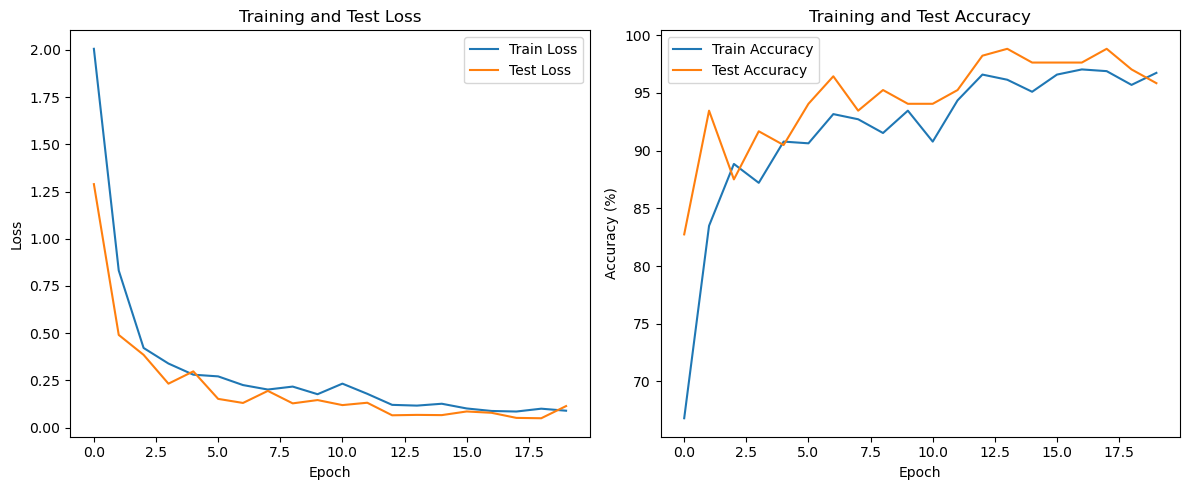

模型已保存到: lstm_predictor.pth


NameError: name 'hot_keys' is not defined

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os
import json
from collections import Counter

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU名称: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# 参数设置
sequence_length = 60  # 用于预测的历史序列长度
batch_size = 32       # 批处理大小
num_epochs = 20       # 训练轮数
learning_rate = 0.001 # 学习率
num_devices = 10      # 设备数量

# 数据加载和预处理函数
def load_and_preprocess_data(file_path):
    """
    加载和预处理访问日志数据
    """
    print("加载数据...")
    df = pd.read_csv(file_path)
    print(f"数据形状: {df.shape}")
    
    # 确保时间戳是整数
    df['timestamp'] = df['timestamp'].astype(int)
    
    # 聚合每秒的访问计数
    print("聚合访问计数...")
    agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
    
    # 确保所有时间戳都有记录
    max_time = df['timestamp'].max()
    agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
    
    # 确保所有设备都有列
    for device_id in range(1, num_devices + 1):
        if device_id not in agg_df.columns:
            agg_df[device_id] = 0
    
    # 按设备ID排序列
    agg_df = agg_df[sorted(agg_df.columns)]
    
    # 重命名列
    agg_df.columns = [f'count_dev{i}' for i in range(1, num_devices + 1)]
    
    return agg_df

# 创建序列数据集
def create_sequences(data, seq_length):
    """
    创建用于LSTM训练的序列数据
    """
    xs, ys = [], []
    
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

# 定义LSTM模型
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 只取最后一个时间步的输出
        out = out[:, -1, :]
        
        # 应用dropout和全连接层
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

# 训练函数
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    """
    训练模型
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # 学习率调度器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    print("开始训练...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # 前向传播
            output = model(data)
            loss = criterion(output, target)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # 统计
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            
            # 每100个batch输出一次进度
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        
        # 计算训练准确率和损失
        train_accuracy = 100. * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # 测试阶段
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()
        
        # 计算测试准确率和损失
        test_accuracy = 100. * test_correct / test_total
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        # 更新学习率
        scheduler.step(avg_test_loss)
        
        # 输出 epoch 结果
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # 输出训练总时间
    end_time = time.time()
    print(f'训练完成! 总耗时: {(end_time - start_time)/60:.2f} 分钟')
    
    return train_losses, test_losses, train_accuracies, test_accuracies


# 预测函数
def predict_next_device(model_path, recent_data, scaler, hot_keys):
    """
    使用训练好的模型预测下一个时间步最可能访问的设备
    并返回该设备的热键
    """
    # 加载模型
    checkpoint = torch.load(model_path)
    
    model = LSTMPredictor(
        checkpoint['input_size'], 
        checkpoint['hidden_size'], 
        checkpoint['num_layers'], 
        checkpoint['num_classes']
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    sequence_length = checkpoint['sequence_length']
    
    # 预处理输入数据
    if len(recent_data) < sequence_length:
        raise ValueError(f"需要至少 {sequence_length} 个时间步的数据，但只提供了 {len(recent_data)} 个")
    
    # 使用最近的数据
    input_data = recent_data[-sequence_length:]
    
    # 标准化
    input_scaled = scaler.transform(input_data)
    
    # 转换为PyTorch张量并添加批次维度
    input_tensor = torch.FloatTensor(input_scaled).unsqueeze(0).to(device)
    
    # 进行预测
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        _, predicted = torch.max(output.data, 1)
        predicted_device = predicted.item() + 1  # 转换为设备ID (1,2,3,...,10)
    
    # 获取预测设备的热键
    predicted_device_hot_keys = hot_keys.get(predicted_device, [])
    
    # 输出预测结果
    print(f"预测下一个时间步最可能访问的设备: 设备{predicted_device}")
    print(f"设备{predicted_device}的热键 (前10个): {predicted_device_hot_keys[:10]}")
    
    for i in range(1, num_devices + 1):
        print(f"设备{i}概率: {probabilities[0][i-1].item()*100:.2f}%")
    
    return predicted_device, predicted_device_hot_keys, probabilities.cpu().numpy()

# 缓存预测器类
class CachePredictor:
    def __init__(self, model_path, hot_keys_path, scaler):
        """
        初始化缓存预测器
        """
        self.model_path = model_path
        self.hot_keys_path = hot_keys_path
        
        # 加载热键信息
        with open(hot_keys_path, 'r') as f:
            hot_keys_str = json.load(f)
        
        # 将字符串键转换为整数
        self.hot_keys = {}
        for device_str, keys in hot_keys_str.items():
            self.hot_keys[int(device_str)] = [int(key) for key in keys]
        
        # 加载模型
        checkpoint = torch.load(model_path)
        
        self.model = LSTMPredictor(
            checkpoint['input_size'], 
            checkpoint['hidden_size'], 
            checkpoint['num_layers'], 
            checkpoint['num_classes']
        ).to(device)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        self.sequence_length = checkpoint['sequence_length']
        self.scaler = scaler
        self.access_history = []  # 存储每个时间步的设备访问计数
    
    def update_history(self, access_counts):
        """更新设备访问历史"""
        self.access_history.append(access_counts)
        # 保持历史长度不超过序列长度
        if len(self.access_history) > self.sequence_length:
            self.access_history = self.access_history[-self.sequence_length:]
    
    def predict_next_device(self):
        """预测下一个可能访问的设备"""
        if len(self.access_history) < self.sequence_length:
            # 历史不足，无法预测
            return None
        
        # 准备输入数据
        input_data = self.access_history[-self.sequence_length:]
        
        # 标准化
        input_scaled = self.scaler.transform(input_data)
        
        # 转换为PyTorch张量并添加批次维度
        input_tensor = torch.FloatTensor(input_scaled).unsqueeze(0).to(device)
        
        # 预测
        with torch.no_grad():
            output = self.model(input_tensor)
            _, predicted = torch.max(output.data, 1)
            predicted_device = predicted.item() + 1  # 转换回1开始的设备ID
        
        return predicted_device
    
    def get_hot_keys_for_device(self, device_id, top_k=10):
        """获取指定设备的热键"""
        if device_id in self.hot_keys:
            return self.hot_keys[device_id][:top_k]
        return []
    
    def preload_cache(self, current_access_counts):
        """
        预加载缓存
        
        参数:
        current_access_counts: 当前时间步的设备访问计数
        
        返回:
        预加载的热键列表
        """
        # 更新历史
        self.update_history(current_access_counts)
        
        # 预测下一个设备
        next_device = self.predict_next_device()
        
        if next_device is not None:
            # 获取下一个设备的热键
            hot_keys = self.get_hot_keys_for_device(next_device)
            print(f"预测下一个访问设备: {next_device}, 预加载热键: {hot_keys[:5]}...")
            return hot_keys
        
        return []
    
def main():

    log_file = '/home/ming/桌面/PLIN-N /PLIN-N/code_demo/workload_logs/workload_log.csv'
    agg_df = load_and_preprocess_data(log_file)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(agg_df.values)
    X, y = create_sequences(scaled_data, sequence_length)

    # 每个时间步访问次数最多的device
    y_labels = np.argmax(agg_df.values[sequence_length:], axis=1)
    
  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y_labels)
    
 
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # train and valid
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], 
        generator=torch.Generator().manual_seed(42)  # 设置随机种子以确保可重复性
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    print(f"训练样本数: {len(train_dataset)}")
    print(f"测试样本数: {len(test_dataset)}")
    
    # model parameter
    input_size = num_devices  # 10个设备的访问计数
    hidden_size = 128
    num_layers = 2
    num_classes = num_devices  # 预测10个设备中的哪一个
    
    model = LSTMPredictor(input_size, hidden_size, num_layers, num_classes).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数总数: {total_params:,}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
        model, train_loader, test_loader, criterion, optimizer, num_epochs
    )
    

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Test Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    model_path = 'lstm_predictor.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'num_classes': num_classes,
        'sequence_length': sequence_length
    }, model_path)
    
    print(f"模型已保存到: {model_path}")
    
    # # 分析热键并保存
    # analyzer = LogAnalyzer(log_file)
    # hot_keys = analyzer.analyze_hot_keys(top_k=100)
    # hot_keys_file = analyzer.save_hot_keys(hot_keys, "hot_keys.json")
    
    return model, hot_keys, scaler

if __name__ == "__main__":
    # 训练模型并获取热键信息
    model, hot_keys, scaler = main()
    
    # # 创建缓存预测器
    # predictor = CachePredictor('lstm_predictor.pth', 'workload_logs/hot_keys.json', scaler)
    
    # # 模拟访问过程
    # print("\n模拟访问过程:")
    
    # # 加载聚合后的数据
    # agg_df = load_and_preprocess_data('workload_logs/workload_log.csv')
    
    # # 只取前1000个时间步进行演示
    # for i in range(min(1000, len(agg_df))):
    #     # 获取当前时间步的设备访问计数
    #     current_access_counts = agg_df.iloc[i].values
        
    #     # 预加载缓存
    #     preloaded_keys = predictor.preload_cache(current_access_counts)
        
    #     # 获取当前时间步访问最多的设备
    #     current_device = np.argmax(current_access_counts) + 1
        
    #     print(f"时间步 {i}: 当前访问最多设备 {current_device}")
        
    #     # 每100个时间步显示一次进度
    #     if i % 100 == 0 and i > 0:
    #         print(f"已处理 {i} 个时间步")